# Ex. 9.6

In [1]:
%matplotlib notebook
import pandas as pd, numpy as np, matplotlib.pyplot as plt
from scipy.interpolate import UnivariateSpline
from itertools import product
from dataclasses import dataclass
from typing import List

SMALL_SIZE = 6
MEDIUM_SIZE = 8
BIGGER_SIZE = 10

plt.rc('axes', titlesize=SMALL_SIZE)     # fontsize of the axes title
plt.rc('axes', labelsize=MEDIUM_SIZE)    # fontsize of the x and y labels
plt.rc('xtick', labelsize=SMALL_SIZE)    # fontsize of the tick labels
plt.rc('ytick', labelsize=SMALL_SIZE)    # fontsize of the tick labels

In [2]:
# number of intervals for wind and temperature
nWind, nTemp = 4, 4
# number of bins each interval have
nBin = 2
data = pd.read_csv('data/Chapter09/ozone.data', sep='\t')
data['ozcr'] = np.power(data.ozone, 1.0 / 3.0)
data['windInterval'] = pd.qcut(data.wind, nWind + nBin - 1)

In [3]:
def plot_prediction(model, modelName: str):
    fig, axMat = plt.subplots(nWind, nTemp)
    fig.set_size_inches((2.2 * nTemp, 2.2 * nWind))
    fig.subplots_adjust(hspace = 0.3)
    for windCat, axRow in zip(range(nWind), axMat):
        dataSubWind = data[data.windInterval.cat.codes.isin(range(windCat, windCat + nBin))].copy()
        dataSubWind['tempInterval'] = pd.qcut(dataSubWind.temperature, nTemp + nBin - 1)
        for tempCat, ax in zip(range(nTemp), axRow):
            dataSubTemp = dataSubWind[dataSubWind.tempInterval.cat.codes.isin(range(tempCat, tempCat + nBin))].copy()
            dataSubTemp.sort_values('radiation', inplace=True)
            windMin, windMax = dataSubTemp.wind.agg([min, max])
            tempMin, tempMax = dataSubTemp.temperature.agg([min, max])
            title = f"wind: ({windMin:.2f}, {windMax:.2f}], temp: ({tempMin:.2f}, {tempMax:.2f}]"
            ax.plot(dataSubTemp.radiation, dataSubTemp.ozcr, '.')
            ax.set_ylim((0, 6))
            ax.set_title(title)
            ax.plot(dataSubTemp.radiation, model.predict(dataSubTemp[['wind','temperature','radiation']]), '-')
            if tempCat == 0:
                ax.set_ylabel('cube root O3')
            if windCat + 1 == nWind:
                ax.set_xlabel('radiation')
    fig.suptitle(modelName)

## (a) Fit an additive model to the cube root of ozone as a function of temperature, wind speed and radiation.

We try to fit an additive model with 3 predictors, each predictor corresponds with a smoothing spline.

\begin{align*}
Y & =\alpha+\Sigma_{j=1}^{3}f_{j}\left(X_{j}\right),\\
\text{where }X_{1} & =\text{wind},\\
X_{2} & =\text{temperature},\\
X_{3} & =\text{radiation}.
\end{align*}

We will use the Backfitting algorithm (9.1) to fit this additive models.

In [4]:
@dataclass
class Backfit:
    data: pd.DataFrame
    predictors: List[str]
    response: str
    def __post_init__(self):
        for pred in self.predictors:
            self.data["PredBy"+pred] = 0.0
        self.alpha = self.data[self.response].mean()
        self.data['pred'] = self.alpha
        
    def predict(self, feature: pd.DataFrame):
        res = pd.Series(index=feature.index, data=self.alpha)
        for pred in self.predictors:
            res[:] += self.Models[pred](feature[pred])
        return res
        
            
    def fit(self, maxIter = 100):
        self.Models= {}
        for i in range(maxIter):
            for pred in self.predictors:
                # For single predictor, we have many duplicates. Use the mean of residual as new response,
                # and the duplicated counts as weight.
                self.data['residual'] = self.data[self.response] - self.data.pred
                dataMar = self.data.groupby(pred).agg(Residual=('residual', 'mean'), 
                                                      Weight=('residual', 'count'),
                                                      LastPred=('PredBy'+pred, 'mean'))
                model = UnivariateSpline(dataMar.index, dataMar.Residual + dataMar.LastPred, w=dataMar.Weight)
                newMarginalPred = model(self.data[pred])
                self.data['pred'] += newMarginalPred - self.data['PredBy'+pred]
                self.Models[pred] = model
                self.data['PredBy'+pred] = newMarginalPred
#             print(f"norm of residual: {np.linalg.norm(bf.data.residual)}")

<IPython.core.display.Javascript object>


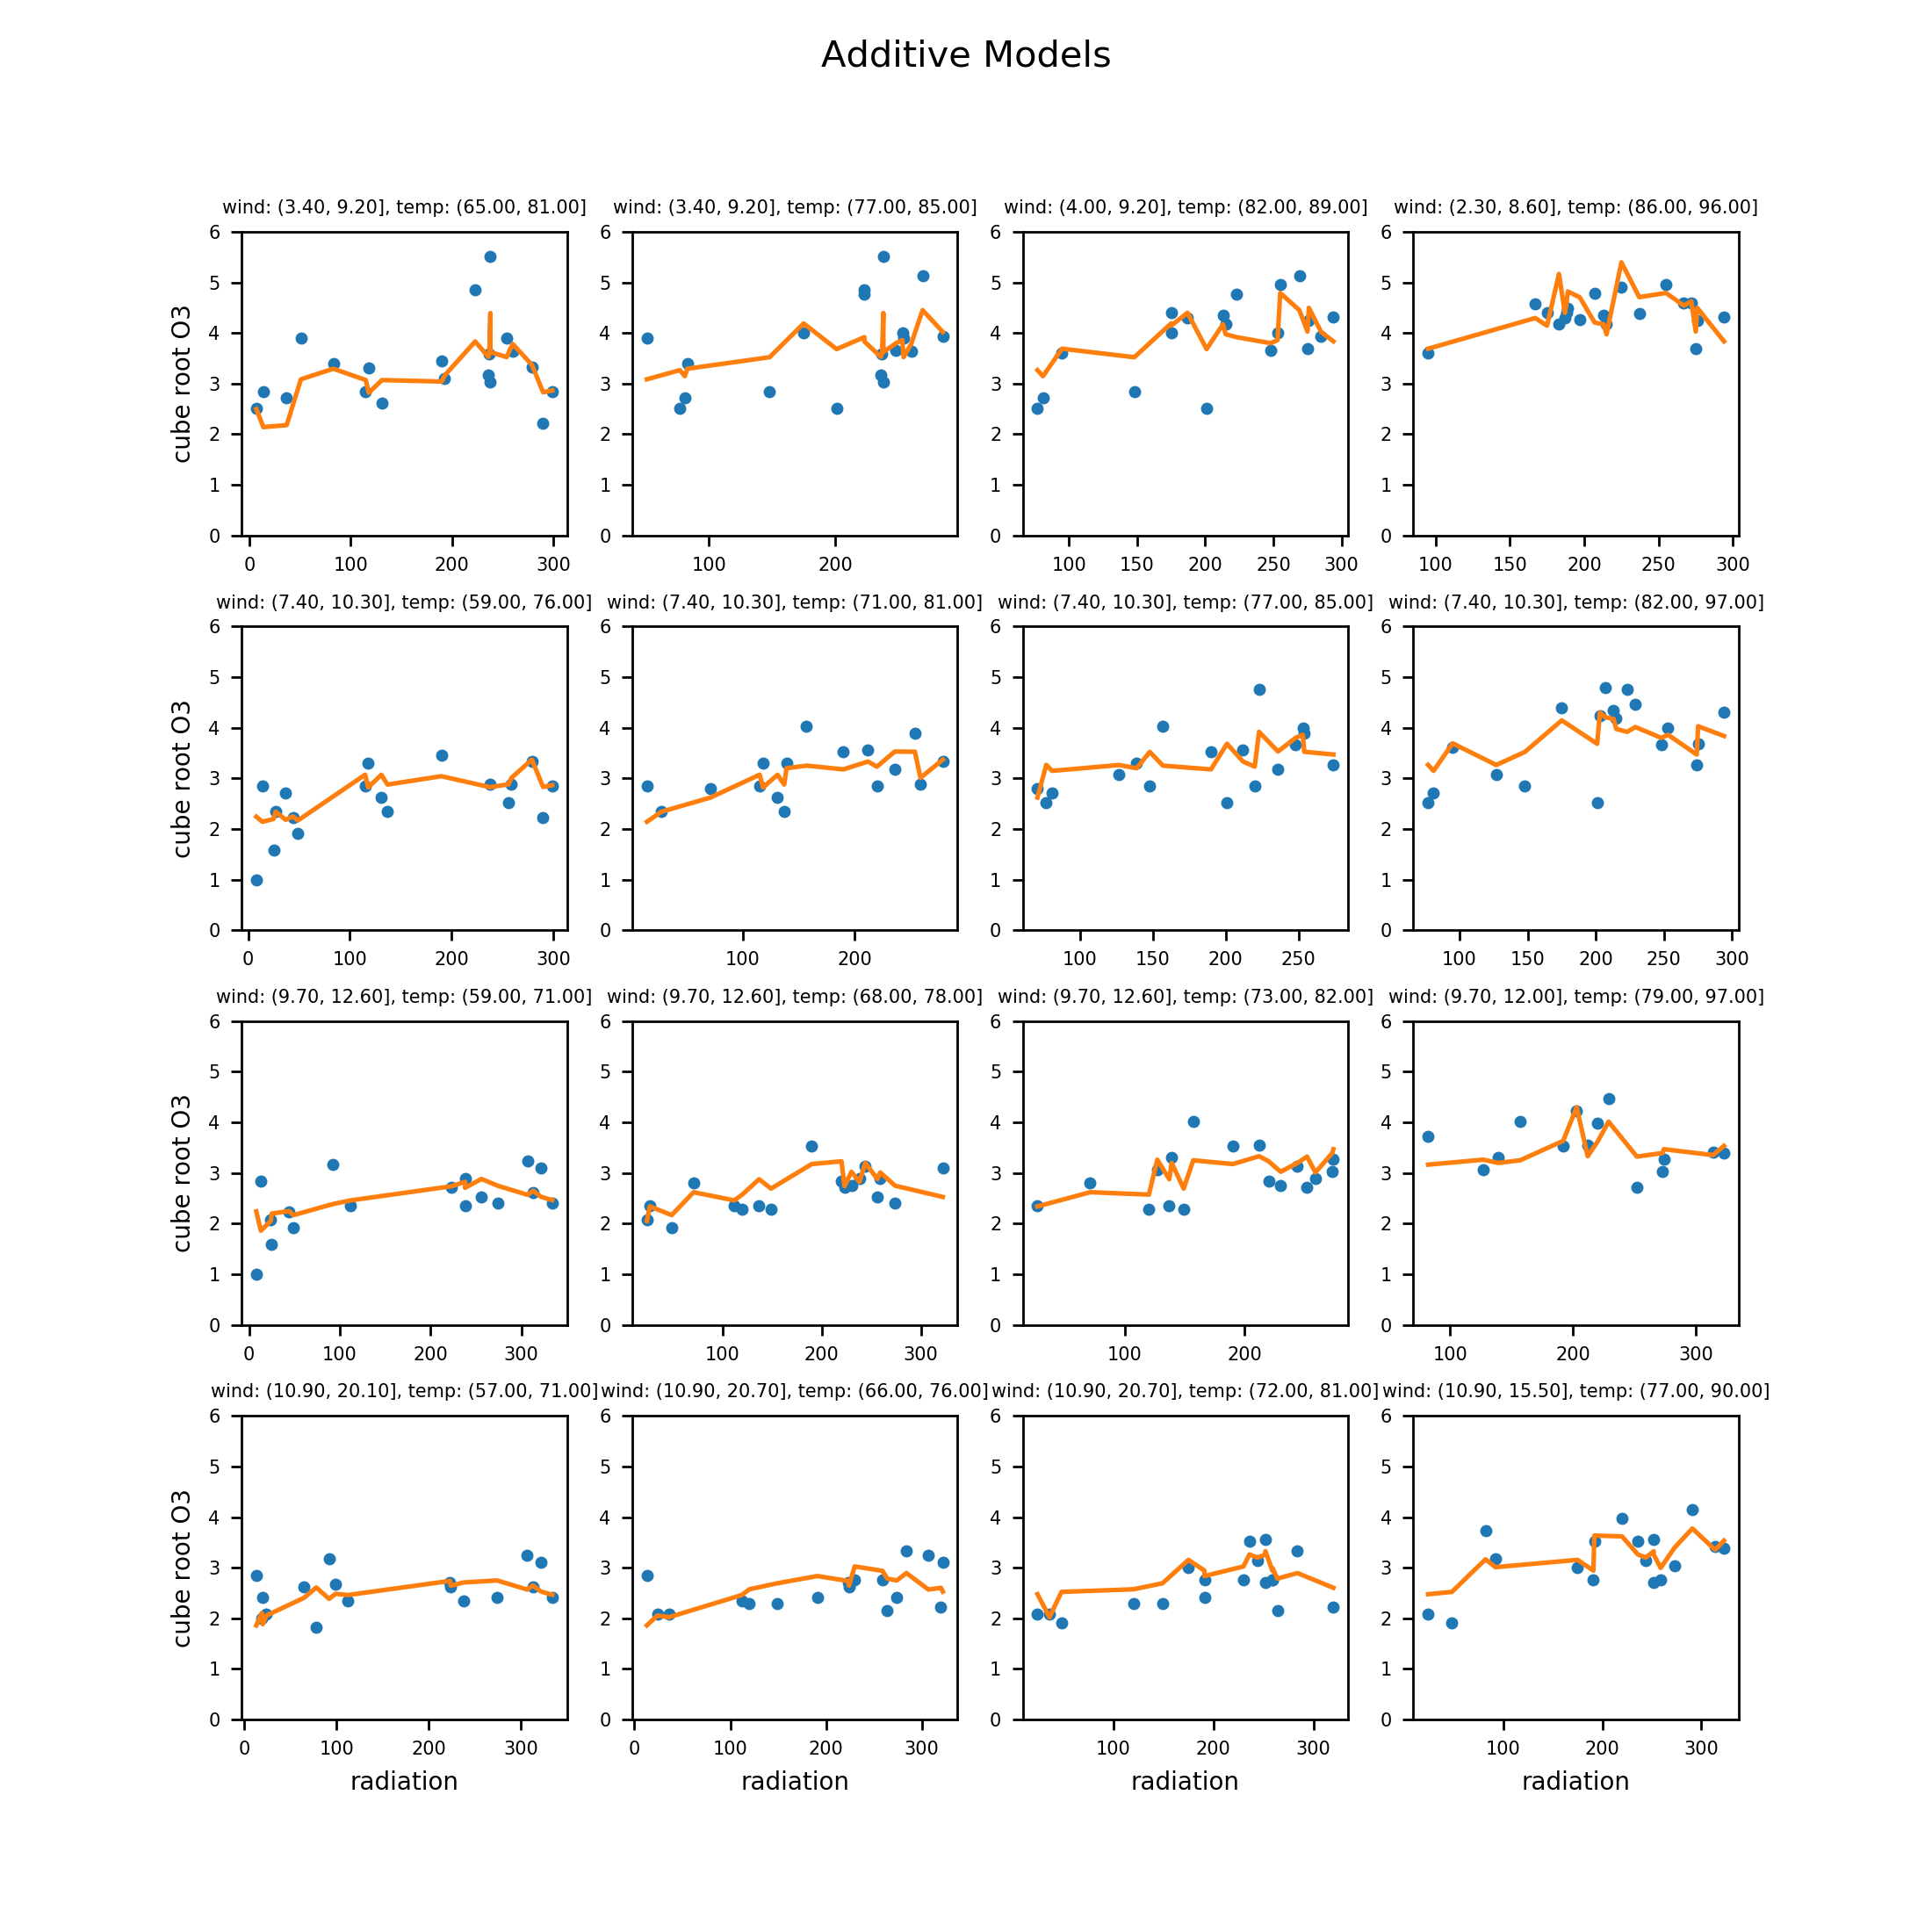

In [5]:
bf = Backfit(data, ['wind', 'temperature', 'radiation'], 'ozcr')
bf.fit(20)
plot_prediction(bf, "Additive Models")

## (b) Fit trees, MARS and PRIM to the same data

In [6]:
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
tr = DecisionTreeRegressor()
tr.fit(data[['wind','temperature','radiation']], data.ozcr)

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=None,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

<IPython.core.display.Javascript object>


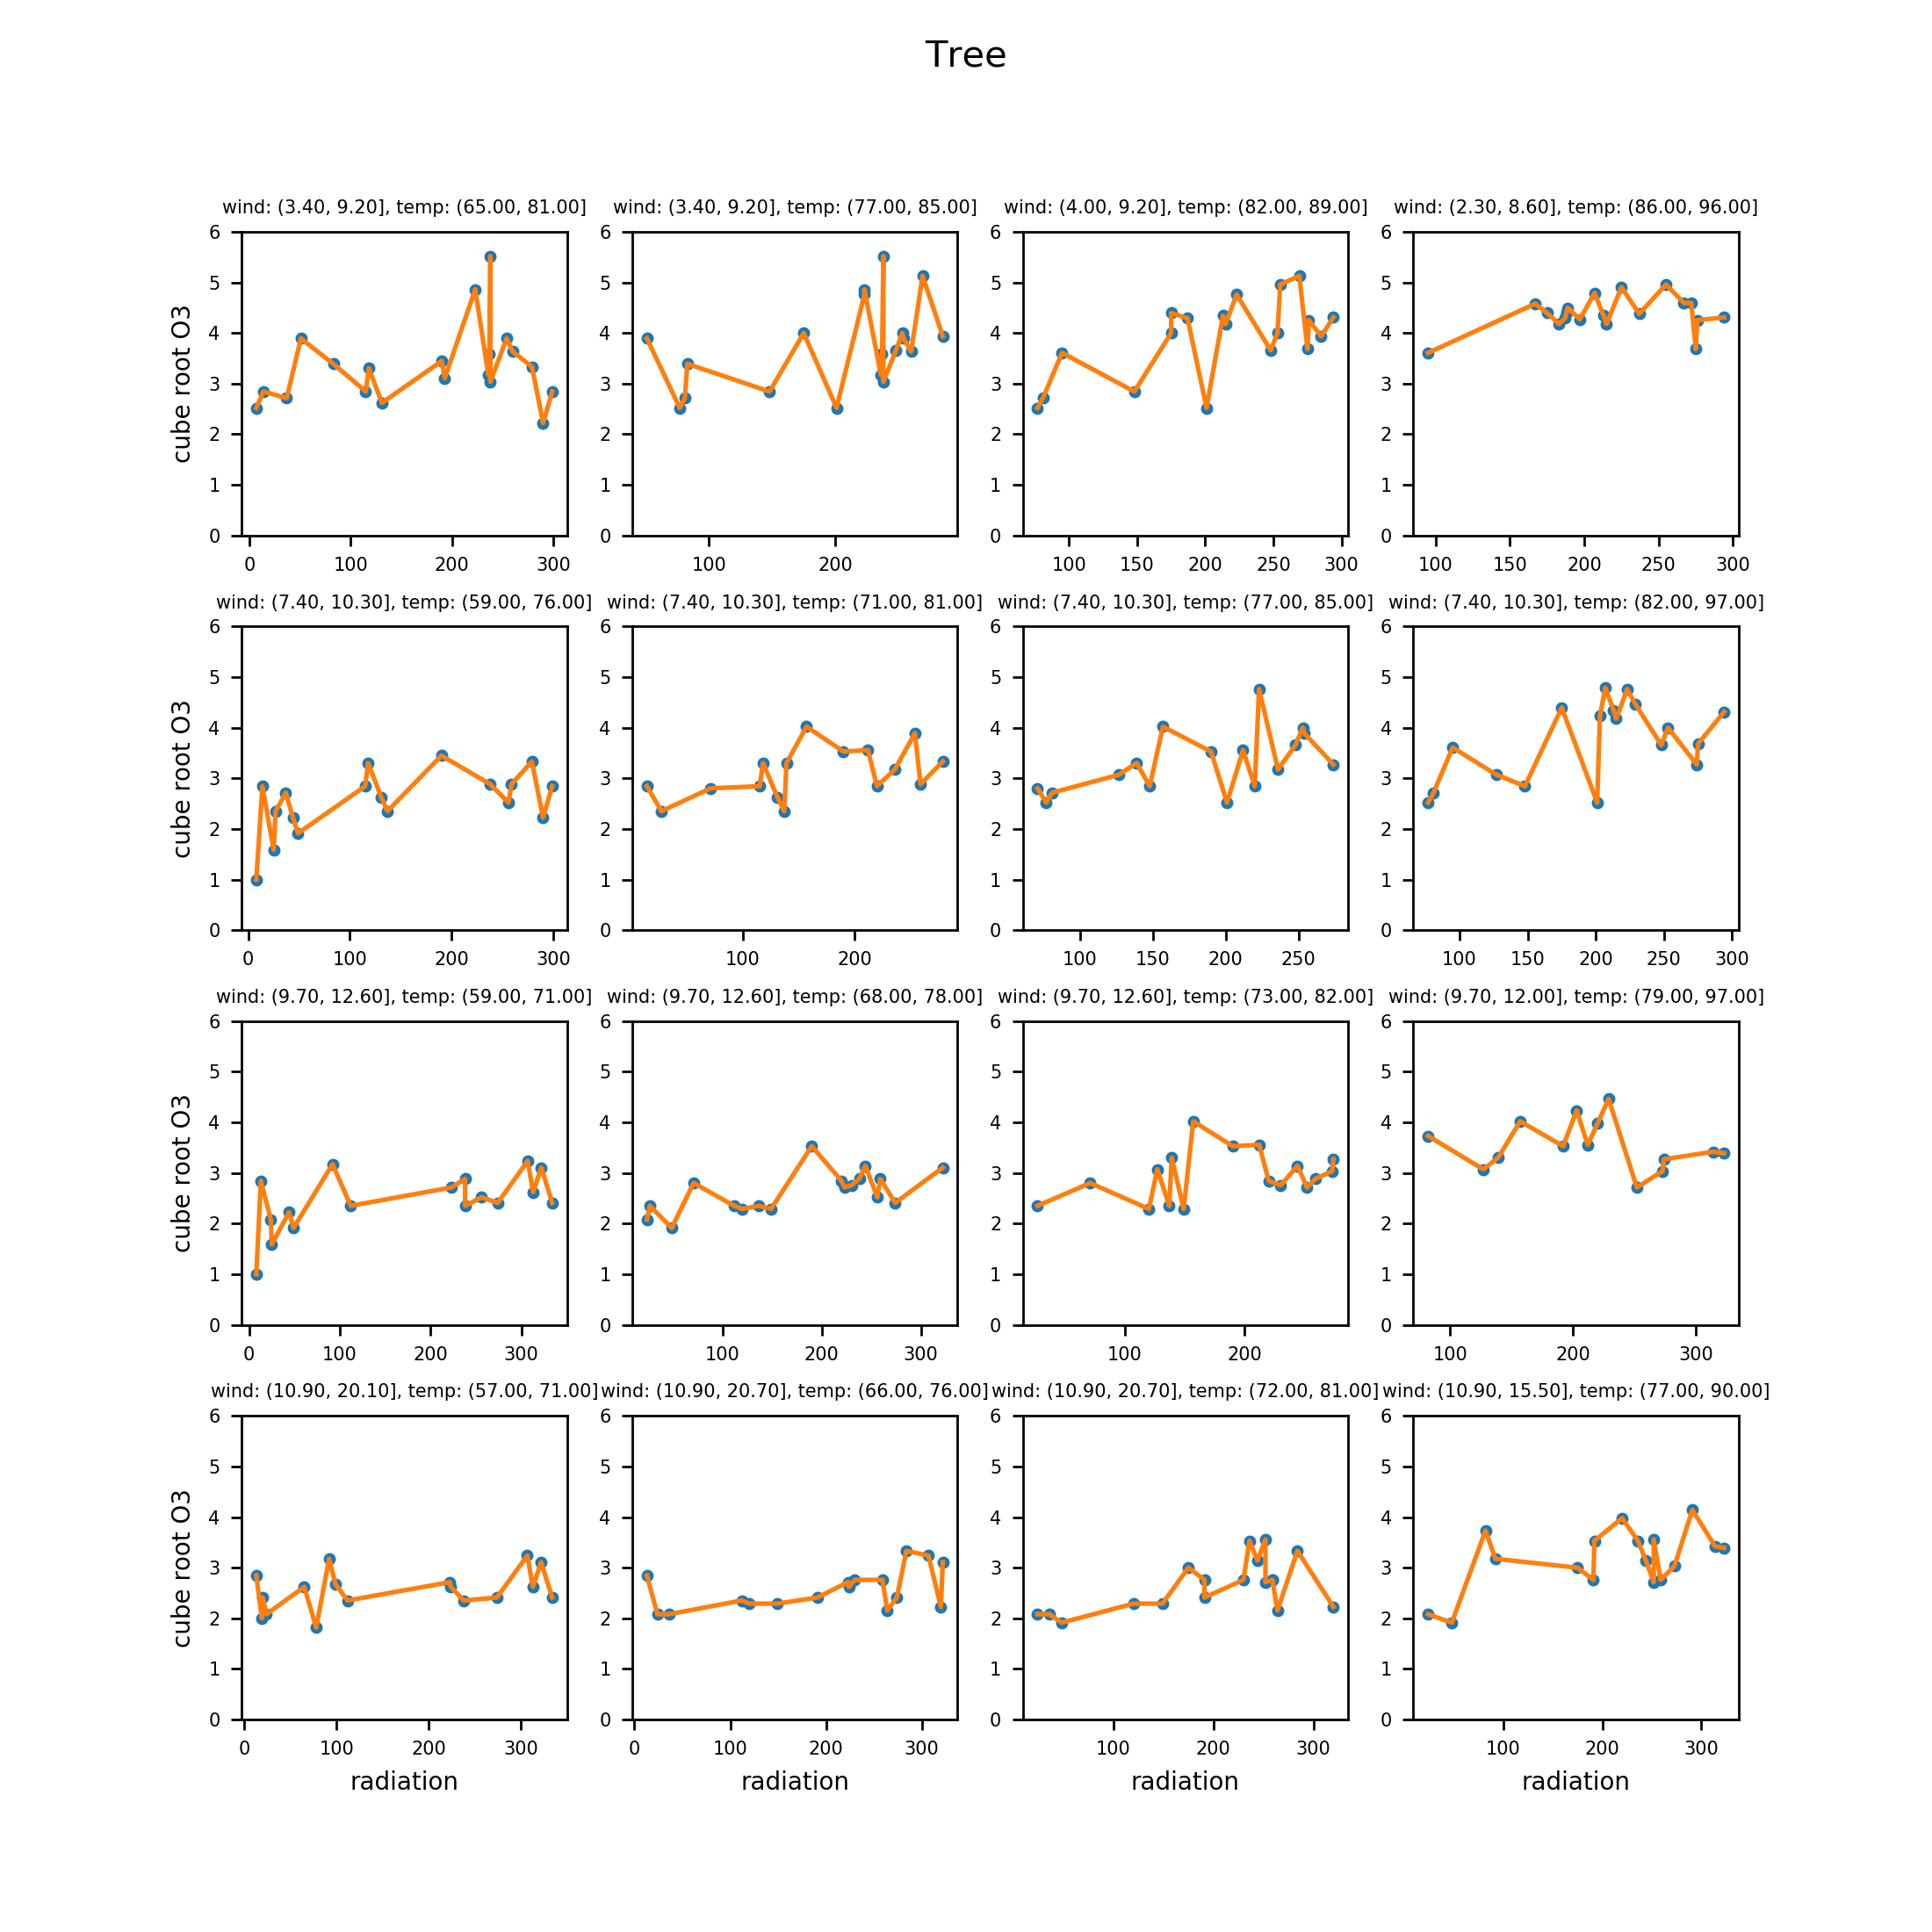

In [7]:
plot_prediction(tr, 'Tree')